In [15]:
!pip install --user logomaker

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 37.1 MB/s eta 0:00:0000:0100:01


In [1]:
from Bio import SeqIO
import logomaker
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.special import softmax
from scipy.stats import entropy
import seaborn as sns
import StringIO

In [2]:
#coordinates = "Chr5:3564493-3565087"
#coordinates = "Chr5:552887-553012"
coordinates = "Chr5:3500000-3600000"
start = int(coordinates.split(":")[1].split("-")[0])
end = int(coordinates.split(":")[1].split("-")[1])

df = pd.read_parquet(f"logits_{coordinates}.parquet")
genome = SeqIO.to_dict(SeqIO.parse("../../data/mlm/tair10.fa", "fasta"))
df["ref_nuc"] = df.apply(lambda row: genome[row.chromosome][row.pos], axis=1)
df.set_index("pos", inplace=True, drop=False)
df

,pos,chromosome,A,C,G,T,ref_nuc
pos,,,,,,,
3500000,3500000,Chr5,0.261700,-0.510872,0.399737,0.259875,A
3500001,3500001,Chr5,0.980765,-0.262463,0.481138,-0.705114,C
3500002,3500002,Chr5,0.554887,-0.531758,-0.234655,0.614921,A
3500003,3500003,Chr5,0.152100,-0.349591,0.674923,-0.029989,G
3500004,3500004,Chr5,0.409633,0.238507,-0.419348,0.230997,C
...,...,...,...,...,...,...,...
3599995,3599995,Chr5,0.256520,-0.629005,0.378055,0.439862,C
3599996,3599996,Chr5,0.351747,-0.415634,0.503562,0.018792,G
3599997,3599997,Chr5,-0.105351,0.421414,-0.115145,0.253361,T


In [3]:
nucleotides = ["A", "C", "G", "T"]

In [4]:
df_llr = df.copy()
for nucleotide in nucleotides:
    df_llr[nucleotide] = df_llr.apply(lambda row: row[nucleotide]-row[row.ref_nuc], axis=1)
df_llr

,pos,chromosome,A,C,G,T,ref_nuc
pos,,,,,,,
3500000,3500000,Chr5,0.000000,-0.510872,0.399737,0.259875,A
3500001,3500001,Chr5,1.243228,0.000000,0.481138,-0.705114,C
3500002,3500002,Chr5,0.000000,-0.531758,-0.234655,0.614921,A
3500003,3500003,Chr5,-0.522823,-1.024514,0.000000,-0.029989,G
3500004,3500004,Chr5,0.171126,0.000000,-0.419348,0.230997,C
...,...,...,...,...,...,...,...
3599995,3599995,Chr5,0.885525,0.000000,0.378055,0.439862,C
3599996,3599996,Chr5,-0.151814,-0.919196,0.000000,0.018792,G
3599997,3599997,Chr5,-0.358712,0.168053,-0.368506,0.000000,T


In [5]:
df.loc[:, nucleotides] = softmax(df[nucleotides].values, axis=1)
df

,pos,chromosome,A,C,G,T,ref_nuc
pos,,,,,,,
3500000,3500000,Chr5,0.277160,0.127999,0.318185,0.276655,A
3500001,3500001,Chr5,0.480656,0.138646,0.291641,0.089057,C
3500002,3500002,Chr5,0.350475,0.118231,0.159134,0.372160,A
3500003,3500003,Chr5,0.242376,0.146760,0.408836,0.202027,G
3500004,3500004,Chr5,0.320963,0.270481,0.140099,0.268457,C
...,...,...,...,...,...,...,...
3599995,3599995,Chr5,0.267169,0.110206,0.301695,0.320930,C
3599996,3599996,Chr5,0.298956,0.138783,0.347968,0.214292,G
3599997,3599997,Chr5,0.195496,0.331063,0.193591,0.279850,T


In [6]:
for nucleotide in nucleotides:
    df[f"ref_1hot_{nucleotide}"] = df.apply(lambda row: 1.0 if row.ref_nuc==nucleotide else 0.0, axis=1)
df

,pos,chromosome,A,C,G,T,ref_nuc,ref_1hot_A,ref_1hot_C,ref_1hot_G,ref_1hot_T
pos,,,,,,,,,,,
3500000,3500000,Chr5,0.277160,0.127999,0.318185,0.276655,A,1.0,0.0,0.0,0.0
3500001,3500001,Chr5,0.480656,0.138646,0.291641,0.089057,C,0.0,1.0,0.0,0.0
3500002,3500002,Chr5,0.350475,0.118231,0.159134,0.372160,A,1.0,0.0,0.0,0.0
3500003,3500003,Chr5,0.242376,0.146760,0.408836,0.202027,G,0.0,0.0,1.0,0.0
3500004,3500004,Chr5,0.320963,0.270481,0.140099,0.268457,C,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
3599995,3599995,Chr5,0.267169,0.110206,0.301695,0.320930,C,0.0,1.0,0.0,0.0
3599996,3599996,Chr5,0.298956,0.138783,0.347968,0.214292,G,0.0,0.0,1.0,0.0
3599997,3599997,Chr5,0.195496,0.331063,0.193591,0.279850,T,0.0,0.0,0.0,1.0


In [7]:
def cross_entropy(y, y_pre):
    return -np.sum(y*np.log(y_pre), axis=1)

In [8]:
true_cols = [f"ref_1hot_{nucleotide}" for nucleotide in nucleotides]
pred_cols = nucleotides
df["cross_entropy"] = cross_entropy(df[true_cols].values, df[pred_cols].values)
df

,pos,chromosome,A,C,G,T,ref_nuc,ref_1hot_A,ref_1hot_C,ref_1hot_G,ref_1hot_T,cross_entropy
pos,,,,,,,,,,,,
3500000,3500000,Chr5,0.277160,0.127999,0.318185,0.276655,A,1.0,0.0,0.0,0.0,1.283159
3500001,3500001,Chr5,0.480656,0.138646,0.291641,0.089057,C,0.0,1.0,0.0,0.0,1.975831
3500002,3500002,Chr5,0.350475,0.118231,0.159134,0.372160,A,1.0,0.0,0.0,0.0,1.048466
3500003,3500003,Chr5,0.242376,0.146760,0.408836,0.202027,G,0.0,0.0,1.0,0.0,0.894441
3500004,3500004,Chr5,0.320963,0.270481,0.140099,0.268457,C,0.0,1.0,0.0,0.0,1.307554
...,...,...,...,...,...,...,...,...,...,...,...,...
3599995,3599995,Chr5,0.267169,0.110206,0.301695,0.320930,C,0.0,1.0,0.0,0.0,2.205400
3599996,3599996,Chr5,0.298956,0.138783,0.347968,0.214292,G,0.0,0.0,1.0,0.0,1.055644
3599997,3599997,Chr5,0.195496,0.331063,0.193591,0.279850,T,0.0,0.0,0.0,1.0,1.273501


In [9]:
df["perplexity"] = np.exp(df.cross_entropy)

<AxesSubplot:ylabel='perplexity'>

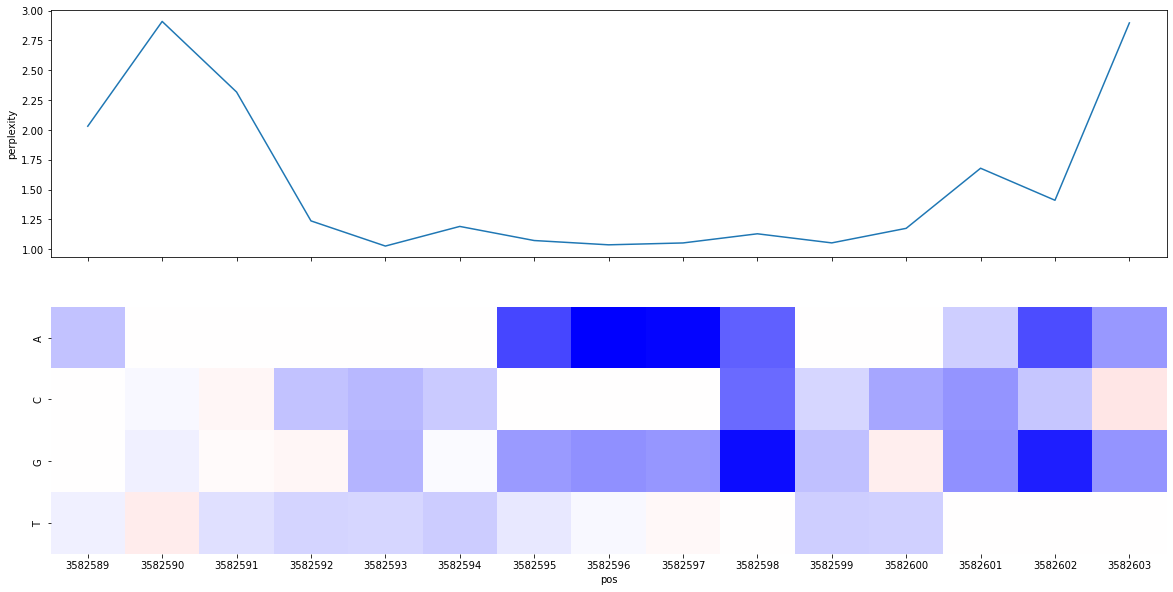

In [12]:
min_pos = 3582589
max_pos = 3582603

#plt.figure(figsize=(40, 5))

fig, axes = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(20, 10))



g = sns.heatmap(
    data=df_llr.loc[min_pos:max_pos, nucleotides].T,
    #square=True,
    cbar=False,
    cbar_kws={"orientation": "vertical", "shrink": .05, "label": "LLR"},
    center=0,
    cmap="bwr",
    #annot=annot,
    #fmt = ''
    ax=axes[1]
)

sns.lineplot(data=df.loc[min_pos:max_pos], y="perplexity", x=g.get_xticks(), ax=axes[0])
#df.loc[min_pos:max_pos].plot(x="pos", y="perplexity", ax=axes[0])
# doesn't work because sns heatmap has a different actual xtick range.

In [14]:
df.loc[min_pos:max_pos]

,pos,chromosome,A,C,G,T,ref_nuc,ref_1hot_A,ref_1hot_C,ref_1hot_G,ref_1hot_T,cross_entropy,perplexity
pos,,,,,,,,,,,,,
3582589,3582589,Chr5,0.162088,0.492459,0.199015,0.146438,C,0.0,1.0,0.0,0.0,0.708345,2.030627
3582590,3582590,Chr5,0.343807,0.190059,0.163484,0.302650,A,1.0,0.0,0.0,0.0,1.067674,2.908605
3582591,3582591,Chr5,0.431566,0.235052,0.220150,0.113233,A,1.0,0.0,0.0,0.0,0.840336,2.317145
3582592,3582592,Chr5,0.808056,0.032374,0.115294,0.044276,A,1.0,0.0,0.0,0.0,0.213124,1.237538
3582593,3582593,Chr5,0.974039,0.007007,0.006540,0.012414,A,1.0,0.0,0.0,0.0,0.026304,1.026653
3582594,3582594,Chr5,0.839504,0.035445,0.088171,0.036880,A,1.0,0.0,0.0,0.0,0.174944,1.191180
3582595,3582595,Chr5,0.031926,0.931940,0.007184,0.028951,C,0.0,1.0,0.0,0.0,0.070487,1.073031
3582596,3582596,Chr5,0.008861,0.964271,0.003436,0.023431,C,0.0,1.0,0.0,0.0,0.036383,1.037053
3582597,3582597,Chr5,0.009767,0.949955,0.004596,0.035682,C,0.0,1.0,0.0,0.0,0.051341,1.052681


Text(0, 0.5, 'information (bits)')

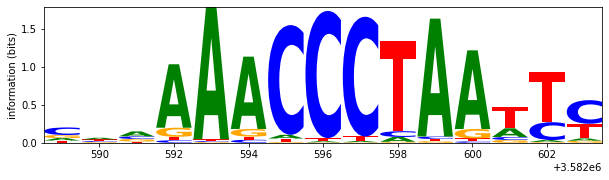

In [36]:
logomaker.Logo(
    logomaker.transform_matrix(df.loc[min_pos:max_pos, nucleotides], from_type="probability", to_type="information"),
)
plt.ylabel("information (bits)")

In [31]:
# http://planttfdb.gao-lab.org/tf.php?sp=Ath&did=AT1G72740.1
# http://planttfdb.gao-lab.org/motif/Ath/AT1G72740.meme
string = """
0.213058	  0.529210	  0.079038	  0.178694
0.237113	  0.546392	  0.116838	  0.099656
0.202749	  0.158076	  0.175258	  0.463918
0.735395	  0.010309	  0.075601	  0.178694
0.969072	  0.010309	  0.006873	  0.013746
0.969072	  0.000000	  0.030928	  0.000000
0.034364	  0.965636	  0.000000	  0.000000
0.000000	  1.000000	  0.000000	  0.000000
0.000000	  1.000000	  0.000000	  0.000000
0.000000	  0.000000	  0.000000	  1.000000
0.993127	  0.000000	  0.003436	  0.003436
0.831615	  0.000000	  0.168385	  0.000000
0.474227	  0.140893	  0.006873	  0.378007
0.030928	  0.443299	  0.054983	  0.470790
0.127148	  0.539519	  0.092784	  0.240550
"""
string

'\n0.213058\t  0.529210\t  0.079038\t  0.178694\n0.237113\t  0.546392\t  0.116838\t  0.099656\n0.202749\t  0.158076\t  0.175258\t  0.463918\n0.735395\t  0.010309\t  0.075601\t  0.178694\n0.969072\t  0.010309\t  0.006873\t  0.013746\n0.969072\t  0.000000\t  0.030928\t  0.000000\n0.034364\t  0.965636\t  0.000000\t  0.000000\n0.000000\t  1.000000\t  0.000000\t  0.000000\n0.000000\t  1.000000\t  0.000000\t  0.000000\n0.000000\t  0.000000\t  0.000000\t  1.000000\n0.993127\t  0.000000\t  0.003436\t  0.003436\n0.831615\t  0.000000\t  0.168385\t  0.000000\n0.474227\t  0.140893\t  0.006873\t  0.378007\n0.030928\t  0.443299\t  0.054983\t  0.470790\n0.127148\t  0.539519\t  0.092784\t  0.240550\n'

In [33]:
true_motif = pd.read_csv(StringIO(string), sep="\t", header=None, names=["A", "C", "G", "T"])
true_motif

,A,C,G,T
0,0.213058,0.529210,0.079038,0.178694
1,0.237113,0.546392,0.116838,0.099656
2,0.202749,0.158076,0.175258,0.463918
3,0.735395,0.010309,0.075601,0.178694
4,0.969072,0.010309,0.006873,0.013746
5,0.969072,0.000000,0.030928,0.000000
6,0.034364,0.965636,0.000000,0.000000
7,0.000000,1.000000,0.000000,0.000000
8,0.000000,1.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,1.000000


Text(0, 0.5, 'information (bits)')

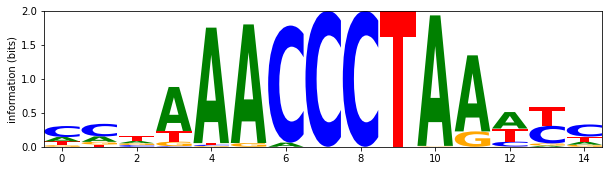

In [35]:
logomaker.Logo(
    logomaker.transform_matrix(true_motif, from_type="probability", to_type="information"),
)
plt.ylabel("information (bits)")

In [47]:
with open(f'wig_perplexity_{coordinates}.txt', 'a') as file:
    file.write(f'fixedStep  chrom=Chr5 start={start+1}  step=1\n')  # check Chr vs. chr
    df.to_csv(file, columns=["perplexity"], header=False, index=False)

In [48]:
!head wig*

fixedStep  chrom=Chr5 start=3500001  step=1
3.6080182634160574
7.212613414699377
2.8532721019041967
2.4459678935679694
3.697120494332242
1.8633079633266865
3.867195624206221
1.6823798226034428
6.682676612531764


In [53]:
!ls wig*

wigToBigWig  wig_perplexity_Chr5:3500000-3600000.txt


In [49]:
!wget http://hgdownload.soe.ucsc.edu/admin/exe/linux.x86_64/wigToBigWig
!chmod +x wigToBigWig

--2022-06-18 13:31:03--  http://hgdownload.soe.ucsc.edu/admin/exe/linux.x86_64/wigToBigWig
Resolving hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)|128.114.119.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9527800 (9.1M)
Saving to: 'wigToBigWig'

100%[======================================>] 9,527,800   5.19MB/s   in 1.7s   

2022-06-18 13:31:04 (5.19 MB/s) - 'wigToBigWig' saved [9527800/9527800]



In [55]:
!ls ../../data/chromatin

Snakefile     intersection.bed		plots		 windows.bed
chrom.sizes   intersection.seq.bed	processed_peaks
datasets      peaks			tair10.fa
find_urls.py  plant_reg_map_source.txt	tracks.tsv


In [56]:
!cat ../../data/chromatin/chrom.sizes

Chr1	30427671
Chr2	19698289
Chr3	23459830
Chr4	18585056
Chr5	26975502


In [57]:
!./wigToBigWig wig_perplexity_Chr5:3500000-3600000.txt ../../data/chromatin/chrom.sizes wig_perplexity_Chr5:3500000-3600000.bw

In [59]:
!ls -sh | grep -i wig

9.1M wigToBigWig
476K wig_perplexity_Chr5:3500000-3600000.bw
1.8M wig_perplexity_Chr5:3500000-3600000.txt
